# Data simulation and model comparison

In this notebook I will simulate data based on the risk and ambiguity task in the aging experiment.

In this version of the task there are 84 trials.

Values: 5, 8, 12, 25

Risk: 0.25, 0.5, 0.75

Ambiguity: 0, 0.24, 0.5, 0.74


## Libraries that will be used in the experiment

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
 
from scipy.special import expit
from scipy import stats, special
from scipy.optimize import minimize 

import pymc3 as pm
import arviz as az
import cmdstanpy

import matplotlib.pyplot as plt
import seaborn as sns

## Load data and simulate participants choices

This file includes all the trials w/o choices

In [2]:
db = pd.read_csv('data/sim.csv')

Here we declare how many participants will be simulated.

risk aversion (α) is taken from a beta distribution with a mean of 0.33, and then multiply by 2 for a final mean of 0.66 (medium risk aversion).

Ambiguity aversion (β) is taken from a truncated normal distribution between -1.5 and 1.5 with a 0.3 average (slight ambiguity aversion).


In [3]:
n_subs = 30

α_true = np.random.beta(2, 4, n_subs)
α_true = α_true * 2
β_true = stats.truncnorm.rvs(-1.5, 1.5, 0.3, size = n_subs)
γ_true = np.random.gamma(1,1,n_subs)+1

value     = np.tile(np.array(db.value),     n_subs)
risk      = np.tile(np.array(db.risk),      n_subs)
ambiguity = np.tile(np.array(db.ambiguity), n_subs)
# noise_sd = 3 # the SD in a normal disterbution mean 0 added to the selection probabilty

In [4]:
refValue       = 5 # constant
refProbability = 1 # constant
refAmbiguity   = 0 # constant

refProbabilities = np.tile(refProbability, len(value))
refValue         = np.tile(refValue,       len(value))
refAmbiguities   = np.tile(refAmbiguity,   len(value))



In [5]:
riskTol = np.repeat(α_true, len(risk) / n_subs)
ambTol  = np.repeat(β_true, len(risk) / n_subs)
gamma   = np.repeat(γ_true, len(risk) / n_subs)

Simulate choice base on the utility function 

add gamma parameter that is not 1
look at correlation between alpha and gamma

In [6]:
uRef = refValue ** riskTol
uLotto = (value ** riskTol) * (risk - (ambTol * ambiguity / 2))
p = 1/(gamma+np.exp(-(uLotto - uRef)))

choice = np.random.binomial(1, p, len(p))

In [7]:
sub_idx = np.arange(n_subs)
sub_idx = np.repeat(sub_idx, 84)
ID = sub_idx+1
n_trials = np.arange(len(choice))

Create a simulation dataframe 

In [8]:
simdata = pd.DataFrame({'sub': ID, 'choice': choice, 'value': value, 'risk': risk, 'ambiguity': ambiguity, 'riskTol': riskTol, 'ambTol': ambTol, 'gamma': gamma})
# simdata.to_csv('results/simdata.csv')
df = simdata
simdata.head()

,sub,choice,value,risk,ambiguity,riskTol,ambTol,gamma
0,1,0,5,0.25,0.00,0.615722,1.710025,1.488523
1,1,0,5,0.50,0.50,0.615722,1.710025,1.488523
2,1,0,12,0.50,0.74,0.615722,1.710025,1.488523
3,1,0,25,0.50,0.74,0.615722,1.710025,1.488523
4,1,0,8,0.50,0.50,0.615722,1.710025,1.488523


In [9]:
sim_group = simdata.groupby(['sub','value','risk','ambiguity']).mean().reset_index()
sim_group.head()

,sub,value,risk,ambiguity,choice,riskTol,ambTol,gamma
0,1,5,0.25,0.00,0.0,0.615722,1.710025,1.488523
1,1,5,0.50,0.00,0.5,0.615722,1.710025,1.488523
2,1,5,0.50,0.24,0.0,0.615722,1.710025,1.488523
3,1,5,0.50,0.50,0.0,0.615722,1.710025,1.488523
4,1,5,0.50,0.74,0.0,0.615722,1.710025,1.488523


<AxesSubplot:xlabel='value', ylabel='choice'>

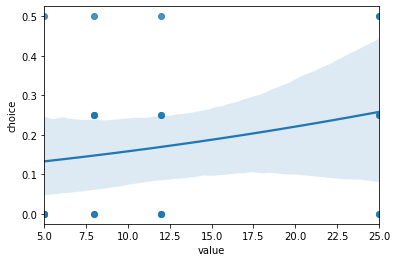

In [10]:
sns.regplot(data = sim_group[sim_group['sub']==1], x='value', y='choice',logistic=True)

## Maximum Likelihood

The first approach I will test is Maximum likelihood. 

In [11]:
def MLE_riskamb(parameters):
    # extract parameters
    α, β, γ = parameters
    
    
    svLotto = (df_mle['value'].values ** α) * (df_mle['risk'].values - (β * (df_mle['ambiguity'].values/2)))
    svRef = 5 ** α
    #p = 1/(1+np.exp((svRef - svLotto) * γ))
    p = sp.special.expit((svLotto - svRef)* γ)

    # Calculate the log-likelihood for normal distribution
    LL = np.sum(stats.norm.logpdf(df_mle.choice, p))
    
    # Calculate the negative log-likelihood
    neg_LL = -1*LL
    return neg_LL 

def MLE_analysis():
    mle_model = minimize(MLE_riskamb, np.array([0.5,0.5,1]), method='L-BFGS-B', bounds=[(0,2),(-1.5,1.5),(-np.inf,np.inf)])
    x = mle_model.x
    return x

In [12]:
subs = df['sub'].unique()
mLL = pd.DataFrame()
for sub in subs:
    df_mle = df[df['sub'] == sub]
    x = MLE_analysis()
    temp = {'sub': sub, 'alpha' : x[0], 'beta': x[1], 'gamma': x[2]}
    mLL = mLL.append(temp,ignore_index=True)

In [13]:
mLL['α_true'] = α_true
mLL['β_true'] = β_true
mLL['γ_true'] = γ_true
mLL['∆α'] = mLL.alpha - mLL.α_true
mLL['∆β'] = mLL.beta - mLL.β_true
mLL['∆γ'] = mLL.gamma - mLL.γ_true
mLL.head()


,sub,alpha,beta,gamma,α_true,β_true,γ_true,∆α,∆β,∆γ
0,1.0,0.157471,1.500000,1.816707,0.615722,1.710025,1.488523,-0.458251,-0.210025,0.328183
1,2.0,0.577469,0.019765,3.164528,0.733623,0.562109,1.089313,-0.156154,-0.542344,2.075215
2,3.0,0.633217,0.106071,1.762893,0.715638,0.180147,1.064525,-0.082421,-0.074076,0.698368
3,4.0,0.000000,1.500000,1.414058,0.093652,-1.080217,2.170238,-0.093652,2.580217,-0.756180
4,5.0,0.499364,1.500000,0.836905,0.644891,1.650409,1.343001,-0.145527,-0.150409,-0.506096


## Next we will look at PYMC3

In [14]:
def pymc_model (df_p, sub_idx, n_subs, ppc = False):

    with pm.Model() as RiskAmb:
        alpha_a = pm.TruncatedNormal('alpha_a', 2, 1, lower = 0.3)
        alpha_b = pm.TruncatedNormal('alpha_b', 2, 1, lower = 0.3)

        bMu = pm.Normal('bMu', 0.3,1)
        bSig = pm.HalfNormal('bSig', .5)

        gMu = pm.TruncatedNormal('gMu', 2, 1, lower = 1)
        gSig = pm.Exponential('gSig', 1)

        alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
        α = pm.Deterministic('α', alpha * 2)
        β = pm.TruncatedNormal('β', bMu, bSig, lower = -2, upper = 2, shape = n_subs)
        gamma = pm.Gamma('gamma', gMu , gSig, shape = n_subs)
        γ = pm.Deterministic('γ', gamma + 1)
        # Expected value of outcome
        svLotto = (df_p['value'].values ** α[sub_idx]) * (df_p['risk'].values - (β[sub_idx] * (df_p['ambiguity'].values/2)))
        svRef = 5 ** α[sub_idx]
        p = 1/(γ[sub_idx]+np.exp(-(svLotto - svRef)))

        # Likelihood (sampling distribution) of observations
        choice = pm.Binomial('choice',1, p, observed=df_p['choice'])

        trace = pm.sample(tune=2000, draws=1000, return_inferencedata=True, target_accept=0.99)
    if ppc:    
        with RiskAmb:   
            ppc = pm.sample_posterior_predictive(trace)
        return (trace, ppc, RiskAmb)
    return (trace)

In [15]:
def pymc_model2 (df_p, sub_idx, n_subs, ppc = False):
    with pm.Model() as RiskAmb:
        aMu = pm.Normal('rMu', 0.7 ,1)
        aSig = pm.Exponential('rSig', 1)
        bMu = pm.Normal('bMu', 0.3,1)
        bSig = pm.HalfNormal('bSig', .5)

        gMu = pm.TruncatedNormal('gMu', 2, 1, lower = 1)
        gSig = pm.Exponential('gSig', 1)


        α = pm.TruncatedNormal('α', aMu, aSig, lower = 0, upper = 2, shape = n_subs)
        β = pm.TruncatedNormal('β', bMu, bSig, lower = -2, upper = 2, shape = n_subs)
        gamma = pm.Gamma('gamma', gMu , gSig, shape = n_subs)
        γ = pm.Deterministic('γ', gamma + 1)
        # Expected value of outcome
        svLotto = (df_p['value'].values ** α[sub_idx]) * (df_p['risk'].values - (β[sub_idx] * (df_p['ambiguity'].values/2)))
        svRef = 5 ** α[sub_idx]
        p = 1/(γ[sub_idx]+np.exp(-(svLotto - svRef)))

        # Likelihood (sampling distribution) of observations
        choice = pm.Binomial('choice',1, p, observed=df_p['choice'])

        trace = pm.sample(tune=2000, draws=1000, return_inferencedata=True, target_accept=0.99)
    if ppc:    
        with RiskAmb:   
            ppc = pm.sample_posterior_predictive(trace)
        return (trace, ppc, RiskAmb)
    return (trace)

In [16]:
def pymc_model3 (df_p, sub_idx, n_subs, ppc = False):

    with pm.Model() as RiskAmb:
        alpha_a = pm.TruncatedNormal('alpha_a', 2, 1, lower = 0.3)
        alpha_b = pm.TruncatedNormal('alpha_b', 2, 1, lower = 0.3)

        bMu = pm.Normal('bMu', 0.3,1)
        bSig = pm.Exponential('bSig', 1)

        alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
        α = pm.Deterministic('α', alpha * 2)
        β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
        γ = pm.Beta('γ', 2 , 2, shape = n_subs)

        # Expected value of outcome
        svLotto = (df_p['value'].values ** α[sub_idx]) * (df_p['risk'].values - (β[sub_idx] * (df_p['ambiguity'].values/2)))
        svRef = 5 ** α[sub_idx]
        p = (1/(1+np.exp(-(svLotto - svRef))))*(1-γ[sub_idx])+γ[sub_idx]*.5

        # Likelihood (sampling distribution) of observations
        choice = pm.Binomial('choice',1, p, observed=df_p['choice'])

        trace = pm.sample(tune=2000, draws=1000, return_inferencedata=True, target_accept=0.99)
        
    if ppc:    
        with RiskAmb:   
            ppc = pm.sample_posterior_predictive(trace)
        return (trace, ppc, RiskAmb)
    return (trace)

In [17]:
trace, ppc, RiskAmb = pymc_model(df, sub_idx, n_subs, ppc=True)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, β, alpha, gSig, gMu, bSig, bMu, alpha_b, alpha_a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 111 seconds.


In [18]:
trace2, ppc2, RiskAmb2 = pymc_model2(df, sub_idx, n_subs, ppc=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, β, α, gSig, gMu, bSig, bMu, rSig, rMu]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 128 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [19]:
trace3, ppc3, RiskAmb3 = pymc_model3(df, sub_idx, n_subs, ppc=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, alpha, bSig, bMu, alpha_b, alpha_a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 142 seconds.


In [20]:
az.compare({'Beta': trace, 'Nomral': trace2, 'trembling-hand': trace3})

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/reve

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Nomral,0,-1308.564257,52.963617,0.000000,1.0,25.112803,0.000000,True,log
Beta,1,-1309.776144,54.734881,1.211887,0.0,25.147696,0.693592,True,log
trembling-hand,2,-1402.811852,33.414992,94.247595,0.0,17.339946,12.517897,True,log


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>]], dtype=object)

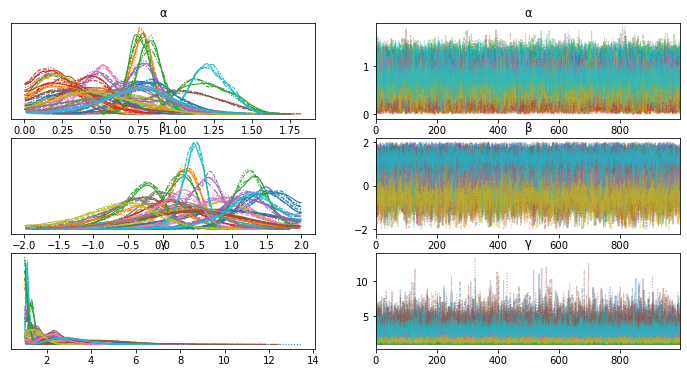

In [21]:
az.plot_trace(trace, var_names=['α','β','γ'])

<AxesSubplot:xlabel='choice / choice'>

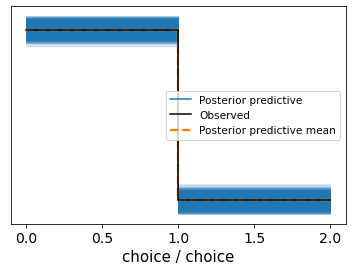

In [22]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=RiskAmb))

In [23]:
α_pymc = az.summary(trace, var_names=['α'])['mean']
β_pymc = az.summary(trace, var_names=['β'])['mean']
γ_pymc = az.summary(trace, var_names=['γ'])['mean']

outcome = pd.DataFrame({'subs':subs,
                        'α_true': α_true, 'α_pymc': α_pymc.values, 'α_MLL': mLL.alpha.values,
                        'β_true': β_true, 'β_pymc': β_pymc.values, 'β_MLL': mLL.beta.values,
                        'γ_true': γ_true, 'γ_pymc': γ_pymc.values, 'γ_MLL': mLL.gamma.values
                       })

In [24]:
outcome.corr()

,subs,α_true,α_pymc,α_MLL,β_true,β_pymc,β_MLL,γ_true,γ_pymc,γ_MLL
subs,1.000000,0.083470,-0.031896,-0.249918,0.051722,-0.050891,-0.207261,0.128026,0.340729,0.263074
α_true,0.083470,1.000000,0.865911,0.686548,0.111446,-0.000292,-0.029749,-0.261552,-0.341183,-0.157304
α_pymc,-0.031896,0.865911,1.000000,0.657179,0.044978,-0.056127,-0.106799,-0.221993,-0.229437,-0.093277
α_MLL,-0.249918,0.686548,0.657179,1.000000,0.009952,-0.072445,0.035790,-0.490923,-0.668943,-0.442679
β_true,0.051722,0.111446,0.044978,0.009952,1.000000,0.658880,0.490247,0.038364,0.099030,0.111754
β_pymc,-0.050891,-0.000292,-0.056127,-0.072445,0.658880,1.000000,0.855608,0.149008,0.142224,0.034971
β_MLL,-0.207261,-0.029749,-0.106799,0.035790,0.490247,0.855608,1.000000,-0.097817,-0.211995,-0.360349
γ_true,0.128026,-0.261552,-0.221993,-0.490923,0.038364,0.149008,-0.097817,1.000000,0.732085,0.578803
γ_pymc,0.340729,-0.341183,-0.229437,-0.668943,0.099030,0.142224,-0.211995,0.732085,1.000000,0.872390
γ_MLL,0.263074,-0.157304,-0.093277,-0.442679,0.111754,0.034971,-0.360349,0.578803,0.872390,1.000000


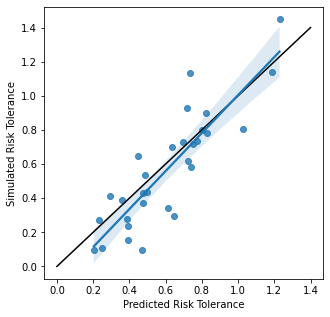

In [25]:
xmax = max(outcome.α_true)
x = np.arange(0, xmax, .05)
y = x

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(y, x, color='black')

sns.regplot(data=outcome, x='α_pymc', y='α_true', ax=ax)
#sns.regplot(data=outcome, x='α_MLL',  y='α_true', ax=ax)
ax.set(xlabel="Predicted Risk Tolerance", ylabel="Simulated Risk Tolerance")

plt.show()

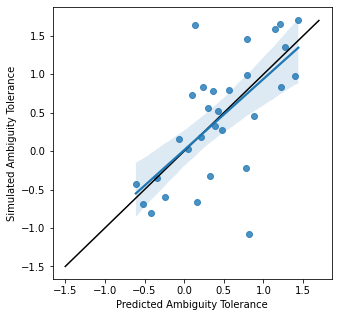

In [26]:
xmax = max(outcome.β_true)
x = np.arange(-1.5, xmax, .05)
y = x

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(y, x, color='black')

sns.regplot(data=outcome, x='β_pymc', y='β_true', ax=ax)
#sns.regplot(data=outcome, x='α_MLL',  y='α_true', ax=ax)
ax.set(xlabel="Predicted Ambiguity Tolerance", ylabel="Simulated Ambiguity Tolerance")

plt.show()

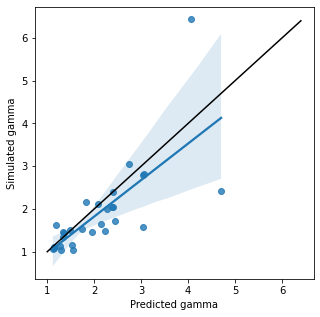

In [27]:
xmax = max(outcome.γ_true)
x = np.arange(1, xmax, .05)
y = x

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(y, x, color='black')

sns.regplot(data=outcome, x='γ_pymc', y='γ_true', ax=ax)
#sns.regplot(data=outcome, x='α_MLL',  y='α_true', ax=ax)
ax.set(xlabel="Predicted gamma", ylabel="Simulated gamma")

plt.show()